## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` read in the `ab_data.csv` data and store it in `df`.  

Read in the dataset and take a look at the top few rows here

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


The number of rows in the dataset.

In [3]:
df.shape[0]

294478

The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

The proportion of users converted.

In [5]:
df['converted'].mean()*100

11.965919355605511

The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('group == "control" & landing_page == "new_page"').shape[0] + df.query('group == "treatment" & landing_page != "new_page"').shape[0]

3893

The rows with missing values.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


<p style='color:red;'>NO MISSING DATA</p>

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

Store new dataframe in **df2**.

In [8]:
df_tmp = df.query('group == "control" & landing_page == "new_page"') + df.query('group == "treatment" & landing_page != "new_page"')
df2 = df.drop(df_tmp.index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Some information 

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

<ul style='color:blue'>
    
- The user_id for the non-unique id in df2. **773192**

- The landing_page for the non-unique id. **`new_page`**

- The group for the non-unique id. **`tretment`**

- The value of converted column for the non-unique id. **0**
</ul>

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
df2.drop([2893], axis=0, inplace=True)

#check
sum(df2.duplicated())

0

`4.` Some probabilities

a. What is the probability of an individual converting regardless of the page they receive?

In [13]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [14]:
df2[df2['group'] == 'control'].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [15]:
df2[df2['group'] == 'treatment'].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [16]:
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

<p style='color:blue'>
1- The probabilty of 'control' group converted is higher than the 'treatment' group converted.<br>
2- The results above do not provide robust evidence.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$ : $p_{new}$ <= $p_{old}$** <br> **$H_{1}$ : $p_{new}$ > $p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br>
Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [17]:
p_new = df2.query("converted == 1").shape[0]/df2.shape[0]
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null?

In [18]:
p_old = df2.query("converted == 1").shape[0]/df2.shape[0]
p_old

0.11959708724499628

In [19]:
p_diff = p_new - p_old
p_diff

0.0

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = df2.query("group == 'treatment'").shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = df2.query("group == 'control'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1-p_new), p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1-p_old), p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.00085854589340585152

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

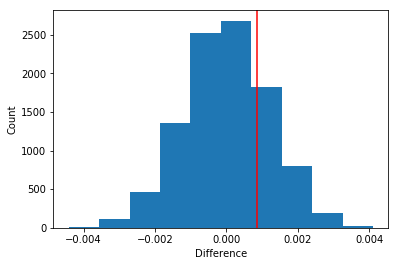

In [26]:
plt.hist(p_diffs);
plt.axvline(x=diff, color='red');
plt.xlabel('Difference');
plt.ylabel('Count');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
p_treatment = df2[df2['group'] == 'treatment'].converted.mean()
p_control = df2[df2['group'] == 'control'].converted.mean()
actual_diff = p_treatment - p_control

p_value = (p_diffs > actual_diff).mean()
p_value

0.90759999999999996

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

<p style='color:blue'> In part j, I calculated the p_value of the hypothesis test. This means that old pages is better than the new one.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df2.query("converted==1 and landing_page=='old_page'").shape[0]
convert_new = df2.query("converted==1 and landing_page=='new_page'").shape[0]
n_old = df2.query("landing_page=='old_page'").shape[0]
n_new = df2.query("landing_page=='new_page'").shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new],[n_old, n_new], alternative='larger')
z_score, 1-p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

<p style='color:blue'> The results agree with one showed in *j and k*

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

<p style='color:blue'>Logistic regression<br></p>
$H_{0}$ : $p_{new}$ - $p_{old}$ = 0 <br> $H_{1}$ : $p_{new}$ - $p_{old}$ ≠ 0 <br>
two-sided t-test

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df2['intercept']=1
df2[['control', 'ab_page']]=pd.get_dummies(df2['group'])

#drop control NO NEED
df2.drop(labels=['control'], axis=1, inplace=True)

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [31]:
mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 16 Nov 2020   Pseudo R-squ.:               8.077e-06
Time:                        15:10:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

<p style='color:blue'>p_value = 0.19 which is greater than significance level = 0.05. <br>
but it is lower than p_value in previous part. (which was equal to 0.9) and maybe the reason is because we randomly take 10000 samples and the diffrence between one tail and two tail test. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<p style='color:blue'>We should consider other factors to make our hypothesis results more robust. <br>The disadvantage that the model will be more complicated.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [33]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [34]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [35]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [36]:
mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US']])
result = mod.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [37]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 16 Nov 2020   Pseudo R-squ.:               1.521e-05
Time:                        15:10:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

p-value of CA is 0.074 which means that it has a minor effect. 

In [38]:
mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])
result = mod2.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [39]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 16 Nov 2020   Pseudo R-squ.:               1.521e-05
Time:                        15:10:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

while your p_value is smaller than in other countries investigated, we are still not able to reject the null as alpha = 5%

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [44]:
df_new['ab_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_US'] = df_new['ab_page'] * df_new['US']
lm3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page','UK' , 'US', 'ab_UK', 'ab_US']])
results = lm3.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 16 Nov 2020   Pseudo R-squ.:               3.482e-05
Time:                        15:12:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
ab_UK          0.0783      0.057      1.378      0.168      -0.033       0.190
ab_US          0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

<a id='conclusions'></a>

NO sufficient evidence showing that there is an interaction between country and page received that will predict whether a user converts or not. But with those info, I suggest to stick to the old website.

In [42]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0